## Imports and Global Variables

In [75]:
# Imports

import json
import os
import pandas as pd
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

In [76]:
# Paths and settings

in_path = "./res_out_dir/results.json"
# Use input dir with no negatives
# in_gt_dir = "/mnt/nis_lab_research/data/coco_files/og/test/ft_test1"
in_gt_dir = "/mnt/nis_lab_research/data/coco_files/og/test/ft_test1_c10"
res_out_path = "./res_out_dir/metrics.txt"
comp_base_dir = "./res_out_dir/comp"


thold = .50

## Functions

In [77]:
def calculate_iou(box1, box2):
    # Extract x, y, w, h from the input boxes
    
    x1 = box1[0]
    y1 = box1[1] 
    w1 = box1[2] 
    h1 = box1[3]
    
    x2 = box2[0]
    y2 = box2[1] 
    w2 = box2[2] 
    h2 = box2[3]
    
    # Determine the coordinates of the intersection rectangle
    x_intersect = max(x1, x2)
    y_intersect = max(y1, y2)
    w_intersect = min(x1 + w1, x2 + w2) - x_intersect
    h_intersect = min(y1 + h1, y2 + h2) - y_intersect
    
    # Ensure the intersection width and height are non-negative
    w_intersect = max(0, w_intersect)
    h_intersect = max(0, h_intersect)
    
    # Compute the area of intersection rectangle
    interArea = w_intersect * h_intersect
    
    # Compute the area of both the prediction and true bounding boxes
    box1Area = w1 * h1
    box2Area = w2 * h2
    
    # Compute the area of union
    unionArea = box1Area + box2Area - interArea
    
    # Compute the Intersection over Union by dividing the intersection area by the union area
    iou = interArea / unionArea if unionArea > 0 else 0.0
    
    return iou


In [78]:
def calculate_int(boxA, boxB):
    
    # Determine the coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    
    # Compute the area of intersection rectangle
    interArea = max(0, xB - xA) * max(0, yB - yA)
    
    return interArea

In [79]:
def draw_bounding_boxes(image_path, gt_bbox_list, pred_bbox_list, output_path, width=3):
    # Open the image
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)

    # Load a font
    font = ImageFont.load_default()

    # Draw bounding boxes and labels
    for bbox in gt_bbox_list:
        x, y, w, h, label = bbox
        draw.rectangle([x, y, x+w, y+h], outline="blue", width=width)
        draw.text((x, y), str(label), fill="blue", font=font)
        
    # Draw bounding boxes and labels
    for bbox in pred_bbox_list:
        x, y, w, h, label = bbox
        draw.rectangle([x, y, x+w, y+h], outline="red", width=width)
        draw.text((x, y), str(label), fill="red", font=font)

    # Save the new image
    image.save(output_path)

In [80]:
def compute_metrics(tp, tn, fp, fn, title, file_path = None):
    
    try:
        accuracy = (tp + tn) / (tp + fp + tn + fn)
        precision = tp/(tp + fp)
        recall = tp/(tp + fn)
        f1_score = 2 * (precision * recall) / (precision + recall)
        print(title)
        print("accuracy: ", accuracy)
        print("precision: ", precision)
        print("recall: ", recall)
        print("f1_score: ", f1_score)
        print()
        
        cm = np.array([[tn, fp], [fn, tp]])

        labels = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
        categories = ['0', '1']

        plt.figure(figsize=(5, 3))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Confusion Matrix - {title}')
        plt.xticks(ticks=np.arange(0.5, 2.5), labels=labels[2:], rotation=45)
        plt.yticks(ticks=np.arange(0.5, 2.5), labels=labels[:2], rotation=0)
        plt.tight_layout()
                
        if file_path:
            
            cm_dir =  os.path.join(os.path.dirname(file_path), "cm")
            os.makedirs(cm_dir, exist_ok=True)
            cm_path = os.path.join(cm_dir, f"{title}.png")
            plt.savefig(cm_path)
            
            with open(file_path, 'a+') as file:
                file.write(f"{title}\n")
                file.write(f"accuracy: {accuracy}\n")
                file.write(f"precision: {precision}\n")
                file.write(f"recall: {recall}\n")
                file.write(f"f1_score: {f1_score}\n\n")
        
        plt.show()
                
    except Exception as e:
        print(title)
        print("Class likely has no instances present. Error message is shown below just in case.")
        print(e)
        print()
        
        if file_path:
            with open(file_path, 'a+') as file:
                file.write(f"{title}\n")
                file.write(f"Class likely has no instances present. Error message is shown below just in case.\n")
                file.write(f"{e}\n\n")

## Loading Data

In [81]:
# Reading in results
### bbox format: (x1, y1, x2, y2)
with open(in_path, "r") as f:
    res_obj = json.load(f)

In [82]:
# Reading in ground truth
### bbox format: (x1, y1, w, h)
with open(os.path.join(in_gt_dir, "result.json"), "r") as f:
    coco_gt_obj = json.load(f)

In [83]:
# Creating map of file basename to results dict for each image

res_map = {}

for res in res_obj:
    fn = os.path.basename(res["file_name"])
    res_map[fn] = res

In [84]:
# Listing working NON NEGATIVE categories

coco_gt_obj["categories"]

[{'id': 0, 'name': 'Advertisement'},
 {'id': 1, 'name': 'Alert Notification'},
 {'id': 2, 'name': 'Button'},
 {'id': 3, 'name': 'Captcha'},
 {'id': 4, 'name': 'Checkbox'},
 {'id': 5, 'name': 'Input Box'},
 {'id': 6, 'name': 'Logo'},
 {'id': 7, 'name': 'Popup'},
 {'id': 8, 'name': 'Toggle Button'},
 {'id': 9, 'name': 'Video'}]

## Grouping GT & Pred by Image

In [85]:
# Group ground truths and predictions by image

imgs_gt_pred_list = {}

tot_num_pred = 0
tot_num_gt = 0

for img in coco_gt_obj["images"]:
    fn1 = img["file_name"].split("/")[-1]
    img_id = img["id"]
    
    gt_list = []

    for ann1 in coco_gt_obj["annotations"]:
        if img_id == ann1["image_id"]:
            x1 = ann1["bbox"][0]
            y1 = ann1["bbox"][1]
            w = ann1["bbox"][2]
            h = ann1["bbox"][3]
            gt_list.append([x1, y1, w, h, ann1["category_id"]])
            tot_num_gt += 1
    
    pred_list = []
    
    for ann2 in res_map[fn1]["annotations"]:
        bbox2 = ann2["bbox"]
        
        ann2_cat_id = ""
        for cat in coco_gt_obj["categories"]:
            if cat["name"] == ann2["category_id"]:
                ann2_cat_id = cat["id"]
                break
                
        bbox2.append(ann2_cat_id)
        pred_list.append(bbox2)
        tot_num_pred += 1
    
    imgs_gt_pred_list[fn1] = [gt_list, pred_list]
            



In [86]:
# Checking num of predictions vs number of ground truths 

print(tot_num_pred)
print(tot_num_gt)

2319
1296


## Calculating IOU Scores

In [87]:
# Calculating IOU scores for all gt and preds that match classes then saving info in a master df


keys = list(imgs_gt_pred_list.keys())
iou_scores = []

os.makedirs(comp_base_dir, exist_ok=True)

for key in keys:
    gts = imgs_gt_pred_list[key][0]
    preds = imgs_gt_pred_list[key][1]
    
    draw_bounding_boxes(os.path.join(in_gt_dir, "images", key) , gts, preds, os.path.join(comp_base_dir, key)) 
    
    for i, pred in enumerate(preds):
        for j, gt in enumerate(gts):
            if int(pred[4]) == int(gt[4]):
                iou = calculate_iou(pred, gt)
                iou_scores.append([key, i, j, iou, pred[4]])
                
iou_scores_df = pd.DataFrame(iou_scores, columns=["fn", "pred_ind", "gt_ind", "iou", "cat_id"])

In [88]:
# Checking size of iou scores df above a certain IOU threshold

len(iou_scores_df[iou_scores_df["iou"] > 0])

1385

In [89]:
# Grouping iou scores df by file name

iou_scores_df_g = iou_scores_df.groupby('fn')

## Calculating TP, FP, TN, FN

In [90]:
# Create dataframes for each image and calculate tp, fp, tn, fn overall and for each class

# Full set of information for each image
iou_full_g_dfs = []
# Only correct matches or TP
iou_corr_g_dfs = []
# Dangling predicted
iou_dang_g_pred_dfs = []
# Dangling ground truths
iou_dang_g_gt_dfs = []
# Overall confusion matrix with single image granularity
conf_mat = []

img_ctr = 0

# Index list of dangling predicted (predictions greater than ground truths)
pred_gtr_gt_list = []
# Index list of dangling groud truths (ground truths greater than predictions)
gt_gtr_pred_list = []

conf_mat_by_class = {}
for i in range(len(coco_gt_obj["categories"])):
    conf_mat_by_class[i] = [0, 0, 0] # for [tp, num pred, num gt]

for name, group in iou_scores_df_g:
    
    print(name)
    
    df_subset = group[["fn", "pred_ind", "gt_ind", "iou", "cat_id"]]
    df_subset = df_subset.sort_values(by="iou", ascending=False)
    df_subset = df_subset.reset_index(drop=True)
    
    iou_full_g_dfs.append(df_subset)
    tp = 0
    
    gt_list = list(df_subset["gt_ind"])
    pred_list = list(df_subset["pred_ind"])
        
    gt_set = list(set(gt_list))
    pred_set = list(set(pred_list))
    
    num_gt = len(gt_set)
    num_pred = len(pred_set)
    
    data_corr = []
    data_pred_dang = []
    data_gt_dang = []
    
    rem_flag = 0
    working_set = None
    
    # Dangling predicted - number of predicted >= number of ground truths 
    if num_pred >= num_gt:
        pred_gtr_gt_list.append(img_ctr)
        working_set = pred_set
        rem_flag = 1
        
    # Dangling ground truths - number of ground truths > number of predicted    
    elif num_gt > num_pred:
        gt_gtr_pred_list.append(img_ctr)
        working_set = gt_set
        rem_flag = 2

    for i, row in df_subset.iterrows():
        
        if rem_flag == 1:
            if row["pred_ind"] in pred_set and row["iou"] > thold:
                data_corr.append(row)
                pred_set.remove(row["pred_ind"])
                tp += 1
            elif row["pred_ind"] in pred_set:
                data_pred_dang.append(row)
                pred_set.remove(row["pred_ind"])
            elif not pred_set:
                break
        elif rem_flag == 2:
            if row["gt_ind"] in gt_set and row["iou"] > thold:
                data_corr.append(row)
                gt_set.remove(row["gt_ind"])
                tp += 1
            elif row["gt_ind"] in gt_set:
                data_gt_dang.append(row)
                gt_set.remove(row["gt_ind"])
            elif not gt_set:
                break
    
    conf_mat_by_class[row["cat_id"]][0] = conf_mat_by_class[row["cat_id"]][0] + tp
    conf_mat_by_class[row["cat_id"]][1] = conf_mat_by_class[row["cat_id"]][1] + num_pred
    conf_mat_by_class[row["cat_id"]][2] = conf_mat_by_class[row["cat_id"]][2] + num_gt
    
    iou_corr_g_dfs.append(pd.DataFrame(data_corr))
    iou_dang_g_pred_dfs.append(pd.DataFrame(data_pred_dang))
    iou_dang_g_gt_dfs.append(pd.DataFrame(data_gt_dang))    
    
    fp = num_pred - tp
    fn = num_gt - tp
    
    conf_mat.append([tp, fp, fn])
    
    img_ctr += 1

0UnHYuFgKVpkj5fl-climbkalymnos_ss.png
0XQJNLHix7U3ywoz-trollalley_ss.png
0aT6ZBE3yco6RgfF-boldgrid_ss.png
1nMggJ5GIIEFbYeI-uncpress_ss.png
2eqOveJE5yU5wT43-2love_ss.png
2gtBmWcoqrZKtL3A-covasoftware_ss.png
3Fty1G9fsbG8f8e2-entiretest_ss.png
3NyyM0qW08CRbchv-squarespace_ss.png
4c7JWiP3yKALOQw8-hans-zimmer_ss.png
5Oig4yqbk5Luwuu3-erome_ss.png
5S0ntCXd3jFIzuCE-multistatesociety_ss.png
5fXW9aZnxNP5f4E6-cbsnews_ss.png
6NVbPqj48y9ThvwT-readthedocs_ss.png
6TEnqJ29XsX8kJpd-games2gether_ss.png
6gFw7bP2szwMmY3G-worldtimebuddy_ss.png
70prigfU3y7EidTs-thrivent_ss.png
7aMKiJmX6TZwNtSg-coloradosbdc_ss.png
82JriSNl6GYwvA8M-etranslate_ss.png
9GGgWUZTjIoHvD8B-tacojohns_ss.png
BRf2llG8abG8XQqf-shopzilla_ss.png
DUvF9dshsgZPicV6-charlestonwineandfood_ss.png
E11t3Z47O6stOyDQ-cantunsee_ss.png
E7hEdIaeabC5bw27-taichiforhealthinstitute_ss.png
Ef6vKkCgKxxyiKU9-mumsandmothers_ss.png
EnEogrLBn43sPmrb-zemanta_ss.png
F0aV6PjF356lX0yJ-beagleboard_ss.png
FYtLhjTVvEzj9MOV-empireminers_ss.png
FvX20nETlFpbQQa7-missouri

In [91]:
# Combining metrics for each image to get overall metrics

tp_tot = 0
fp_tot = 0
fn_tot = 0

for img in conf_mat:
    tp_tot = tp_tot + img[0]
    fp_tot = fp_tot + img[1]
    # Would be equivalent to correctly identifying areas where no object is present... so we set it to 0 because it is not relevant
    tn_tot = 0
    fn_tot = fn_tot + img[2]
    

## Data Inspection

In [92]:
# Quick visual to assess which dangling case was more prevelant

print(len(pred_gtr_gt_list))
print(pred_gtr_gt_list)
print(len(gt_gtr_pred_list))
print(gt_gtr_pred_list)

93
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 76, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 92, 93, 94, 95, 96, 97, 98]
6
[30, 40, 52, 75, 77, 91]


In [93]:
voi = 11

In [94]:
iou_full_g_dfs[voi]

,fn,pred_ind,gt_ind,iou,cat_id
0,5fXW9aZnxNP5f4E6-cbsnews_ss.png,4,6,0.800985,2
1,5fXW9aZnxNP5f4E6-cbsnews_ss.png,12,4,0.773592,2
2,5fXW9aZnxNP5f4E6-cbsnews_ss.png,6,3,0.759422,2
3,5fXW9aZnxNP5f4E6-cbsnews_ss.png,1,11,0.742662,2
4,5fXW9aZnxNP5f4E6-cbsnews_ss.png,20,12,0.709196,2
...,...,...,...,...,...
264,5fXW9aZnxNP5f4E6-cbsnews_ss.png,7,0,0.000000,2
265,5fXW9aZnxNP5f4E6-cbsnews_ss.png,7,2,0.000000,2
266,5fXW9aZnxNP5f4E6-cbsnews_ss.png,7,3,0.000000,2
267,5fXW9aZnxNP5f4E6-cbsnews_ss.png,7,4,0.000000,2


In [95]:
iou_corr_g_dfs[voi]

,fn,pred_ind,gt_ind,iou,cat_id
0,5fXW9aZnxNP5f4E6-cbsnews_ss.png,4,6,0.800985,2
1,5fXW9aZnxNP5f4E6-cbsnews_ss.png,12,4,0.773592,2
2,5fXW9aZnxNP5f4E6-cbsnews_ss.png,6,3,0.759422,2
3,5fXW9aZnxNP5f4E6-cbsnews_ss.png,1,11,0.742662,2
4,5fXW9aZnxNP5f4E6-cbsnews_ss.png,20,12,0.709196,2
5,5fXW9aZnxNP5f4E6-cbsnews_ss.png,5,10,0.677539,2
6,5fXW9aZnxNP5f4E6-cbsnews_ss.png,7,1,0.655931,2
7,5fXW9aZnxNP5f4E6-cbsnews_ss.png,2,13,0.652072,2
8,5fXW9aZnxNP5f4E6-cbsnews_ss.png,19,2,0.651441,2
9,5fXW9aZnxNP5f4E6-cbsnews_ss.png,8,5,0.618257,2


In [96]:
iou_dang_g_pred_dfs[voi]

,fn,pred_ind,gt_ind,iou,cat_id
15,5fXW9aZnxNP5f4E6-cbsnews_ss.png,3,12,0.390478,2
16,5fXW9aZnxNP5f4E6-cbsnews_ss.png,22,15,0.163203,0
24,5fXW9aZnxNP5f4E6-cbsnews_ss.png,14,9,0.000000,6
44,5fXW9aZnxNP5f4E6-cbsnews_ss.png,10,1,0.000000,2
79,5fXW9aZnxNP5f4E6-cbsnews_ss.png,18,9,0.000000,6
109,5fXW9aZnxNP5f4E6-cbsnews_ss.png,16,6,0.000000,2
112,5fXW9aZnxNP5f4E6-cbsnews_ss.png,9,14,0.000000,2


In [97]:
iou_dang_g_gt_dfs[voi]

""


## Computing Final Metrics

OVERALL
accuracy:  0.4304857621440536
precision:  0.47460757156048017
recall:  0.8224
f1_score:  0.6018735362997658



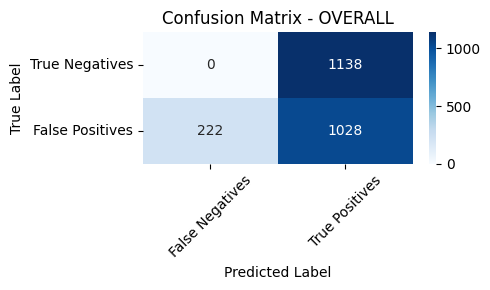

(0, [19, 77, 40])
CLASS 0 - Advertisement
accuracy:  0.19387755102040816
precision:  0.24675324675324675
recall:  0.475
f1_score:  0.3247863247863248



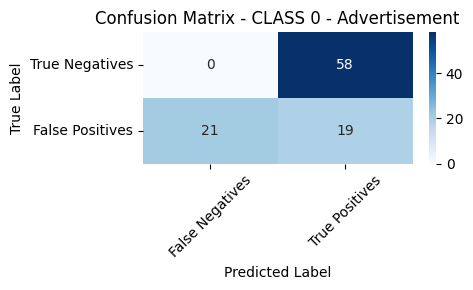

(1, [92, 174, 93])
CLASS 1 - Alert Notification
accuracy:  0.5257142857142857
precision:  0.5287356321839081
recall:  0.989247311827957
f1_score:  0.6891385767790262



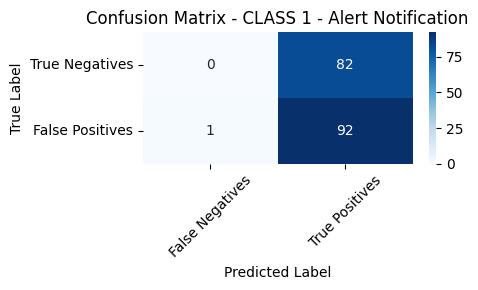

(2, [852, 1781, 1033])
CLASS 2 - Button
accuracy:  0.43425076452599387
precision:  0.4783829309376755
recall:  0.8247821878025169
f1_score:  0.605543710021322



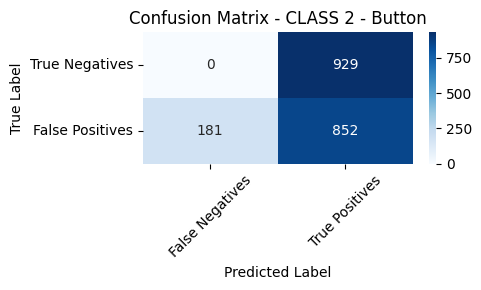

(3, [0, 0, 0])
CLASS 3 - Captcha
Class likely has no instances present. Error message is shown below just in case.
division by zero

(4, [0, 0, 0])
CLASS 4 - Checkbox
Class likely has no instances present. Error message is shown below just in case.
division by zero

(5, [8, 12, 15])
CLASS 5 - Input Box
accuracy:  0.42105263157894735
precision:  0.6666666666666666
recall:  0.5333333333333333
f1_score:  0.5925925925925926



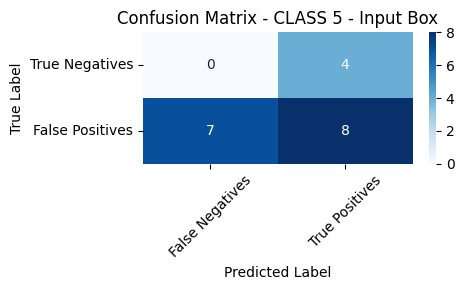

(6, [39, 80, 49])
CLASS 6 - Logo
accuracy:  0.43333333333333335
precision:  0.4875
recall:  0.7959183673469388
f1_score:  0.6046511627906976



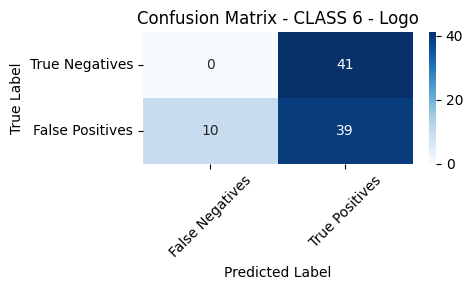

(7, [2, 10, 2])
CLASS 7 - Popup
accuracy:  0.2
precision:  0.2
recall:  1.0
f1_score:  0.33333333333333337



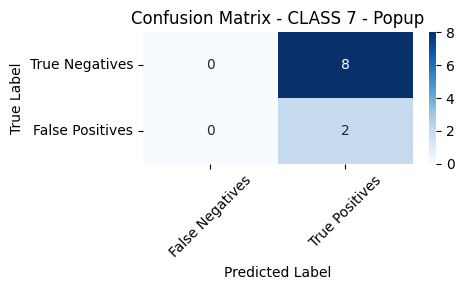

(8, [0, 0, 0])
CLASS 8 - Toggle Button
Class likely has no instances present. Error message is shown below just in case.
division by zero

(9, [16, 32, 18])
CLASS 9 - Video
accuracy:  0.47058823529411764
precision:  0.5
recall:  0.8888888888888888
f1_score:  0.64



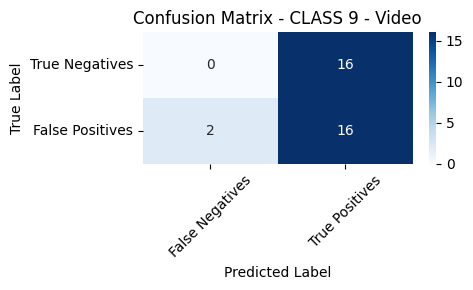

In [98]:
# Computing relevant metrics

# fp = num_pred - tp
# fn = num_gt - tp

# Deleting old results if exit
f = open(res_out_path, "w+")
f.close()

compute_metrics(tp_tot, tn_tot, fp_tot, fn_tot, "OVERALL", res_out_path)
for item in conf_mat_by_class.items():
    print(item)
    tp = item[1][0]
    tn = 0
    fp = item[1][1] - item[1][0]
    fn = item[1][2] - item[1][0]
    compute_metrics(tp, tn, fp, fn, f"CLASS {item[0]} - {coco_gt_obj['categories'][item[0]]['name']}", res_out_path)